<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/7_multi_model_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Ayesha Khan

# Read forecast results of all trained models, ie.

1. Autoregressive SARIMAX
2. MLP
3. LSTM
4. PatchTST

Below is the code I used to save the forecasts of the previous models. The first code block contains the function I defined and the second code block is the usage of the function. I used both in the previous notebooks where the models were run.

Google Drive URLS for loading the saved results are written.

The plotting function is written after the results are read in.

The plotter works for any time period and station (it just needs to be specified which time period and station we want to see). Assuming that we always use the same master dataset (all use create sequences function as well), index of first X_test would be sufficient to ID time period.





But the issue with loading all the data into memory for training meant that I could not get the context data used in the ML models.
I used the context data in the Autoregessive models and reduced the time range as suggested, but now the plots are wrong because the SARIMA model is using a different (part) of the dataset than the ML models. To get the results for the ML models I used the checkpointed model and used it only for inference, so I could not find the slice of the dataset that I used for SARIMAX (because I dont know how to work with pickled files). I hope to work on this after the other two tasks.

Please consider that I ran out of Colab compute by the time I uploaded the pickled data for the PatchTST model. I also lost work a couple of times because of trying to open another notebook for reference in the same tab.

(Though I admit it could have been avoided by starting earlier.)

But I am struggling in Colab environment... 🏳🏳🏳

# Observations:

These are from the previous notebooks, not the messy plot here..


1.   SARIMA shows a warming trend which matches the true data in the 96 hour forecast, but it underestimates peak temperature and lags behind ground truth.
2.   MLP model more accurately showed the temperature oscillations and predicting the peak events.
3. LSTM showed problems with tracking peaks, underestimating or overestimating them.  



Other small issues:

1. In Notebook 3: create sequences function : the comment says 24 hour past values and 6 hours for future, but 336 and 96 used. ie. 2 weeks and 4 days. or am I missing something?
2. It is not clear to me if we should modify previous notebooks to save forecast results and then read them in here, because then I will have to write the execution code here and comment it out to show it to evaluator.
Was I to move all model codes into one notebook?


In [1]:
# Mount google drive when working in colab
hasCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if hasCOLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  BASEPATH = '/content/drive/MyDrive'
else:
  BASEPATH = '.'

Mounted at /content/drive


In [2]:
# URL of results folder for evaluator
url = "https://drive.google.com/drive/folders/1jEdUKJRgI0EwJmAfnc3y7RAT8I58tIAj?usp=drive_link"

In [3]:
# function to save forecast results in a structured format

import numpy as np
import json
import os

def save_forecast(
        station: str,
        model: str,
        context_vals,               # 1-D array-like, X test values
        future_true,                # 1-D array-like, true future values
        future_pred,                # 1-D array-like, predicted future values
        episode_id,                 # int index, to identify the timeperiod
        folder=f"{BASEPATH}/results"): # default folder for results
    """
    One call per model-run. Stores just enough metadata to let the
    plotting notebook know what it’s looking at.
    """
    import os, json, numpy as np
    # make sure the base path exists
    os.makedirs(folder, exist_ok=True)

    # structure the result
    # note: context_vals, future_true, and future_pred should be 1-D arrays
    result = {
        "station":        station,              # <- allows filtering
        "episode_id":     episode_id,           # <- allows filtering
        "model":          model,                # <- allows choosing of model
        "context":        np.asarray(context_vals).tolist(),    # converts to numpy array and then to list
        "future_true":    np.asarray(future_true).tolist(),
        "future_pred":    np.asarray(future_pred).tolist()
    }

    # create a filename based on model, station, and episode_id
    fname = f"{model}_{station}_{episode_id}.json"

    # save the result to a JSON file
    with open(os.path.join(folder, fname), "w") as f:
        json.dump(result, f, indent=2)

    # let user know station code and episode_id for plotting purpose
    print(f"Results saved as {fname}, episode_id is {episode_id} and station is {station}")


In [4]:
# Example usage for SARIMA:

# episode_id = int(X_first_idx)  # Convert to native Python int


# save_forecast(
#     station="DENW094",
#    model="SARIMA",
#    context_vals=X_test_sample,
#    future_true=y_test_sample,
#    future_pred=forecast_values,
#    episode_id=episode_id
#)



## Plotter

In [5]:
import json
import glob # for file handling
import matplotlib.pyplot as plt
import warnings

# Function to load all saved runs from the results folder
def load_runs(run_dir, station, episode_id):
    """
    Loads runs from specified directory. Needs station number and episode_id to ensure the same timeperiod and location is loaded for accurate comparison between models.
    Returns list of results in json structure.
    """

    # initialize list to store run data
    runs = []
    for path in glob.glob(f"{run_dir}/*.json"): # get all filepaths of result files
        try:
            with open(path) as f:
                r = json.load(f) # load contents of each file
        except json.JSONDecodeError as e:
            warnings.warn(f"Could not load {path} as JSON: {e}")
            # Print the content of the file that caused the error
            with open(path, 'r') as f_err:
                print(f"Content of problematic file '{path}':\n{f_err.read()}")
            continue # skip to the next file
        if r["station"] == station and r["episode_id"] == episode_id: # check if results file matches the desired station and episode_id
            runs.append(r)
    return runs

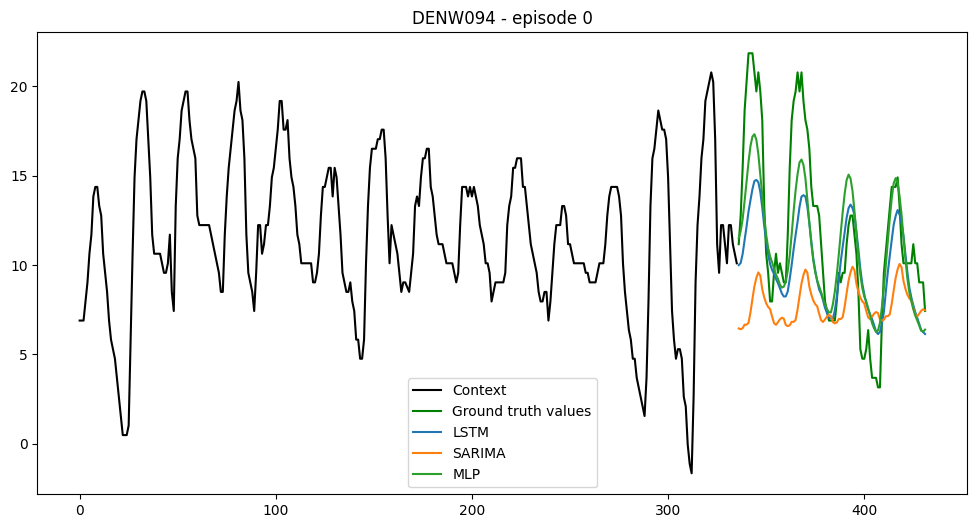

In [10]:
# --- choose what to visualize ---
station = "DENW094"
episode_id = 0
# setting results folder according to my google drive
runs = load_runs(f"{BASEPATH}/results", station, episode_id)

# shared x-axis
context_length = len(runs[1]["context"]) # length of past values of variable
future_length = len(runs[0]["future_true"]) # length of forecasted value array
context_xaxis = range(context_length) # creating time step values for x axis for the past value range
future_xaxis = range(context_length, context_length + future_length) # creating timestep values for x axis for forecasted values range

plt.figure(figsize=(12,6))
plt.plot(context_xaxis, runs[2]["context"], label = "Context", color="black") # plot past values of variable
plt.plot(future_xaxis, runs[2]["future_true"], label = "Ground truth values", color = "green") # plot ground truth values of the variable

# loop over all model results
for r in runs:
    plt.plot(future_xaxis, r["future_pred"], label = r["model"]) # plot predicted value from model

plt.title(f"{station} - episode {episode_id}")
plt.legend()
plt.tight_layout
plt.show()